In [1]:
import sys
import os
sys.path.append(os.path.abspath('../../'))

from rcgp.morcgp import MOGPRegressor, MORCGPRegressor, MOGPRegressor_NC, MORCGPRegressor_NC, MORCGPRegressor_NC_fixed_weights, MORCGPRegressor_fixed_weights, MORCGPRegressor_PM
from rcgp.rcgp import RCGPRegressor
from rcgp.kernels import ConstantMean, RBFKernel, SineMean
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams.update({
    "text.usetex": True,         
    "font.family": "serif",       
    "text.latex.preamble": r"\usepackage{amsmath}",
    'font.size': 24,         
    'axes.labelsize': 24,    
    'xtick.labelsize': 24,   
    'ytick.labelsize': 24,  
    'legend.fontsize': 20,
    'lines.linewidth': 4,    
    'lines.markersize': 5   
})

## Simulation

Methods for simulation

In [2]:
def train_test_split_random(x, Y, N_train):
    total_samples = x.shape[0]
    all_indices = np.arange(total_samples)
    
    # Randomly select training indices without replacement
    train_indices = np.random.choice(all_indices, size=N_train, replace=False)
    test_indices = np.setdiff1d(all_indices, train_indices)
    
    # Sort indices (optional, for consistent ordering)
    train_indices = np.sort(train_indices)
    test_indices = np.sort(test_indices)
    
    # Create splits
    x_train = x[train_indices]
    Y_train = Y[train_indices]
    x_test = x[test_indices]
    Y_test = Y[test_indices]
    
    return x_train, Y_train, x_test, Y_test

def introduce_missing_values(Y, missing_percentage):
    # Flatten the array and get total number of elements
    num_elements = Y.size
    num_nan = int(missing_percentage * num_elements)

    # Randomly choose indices to set to NaN
    nan_indices = np.random.choice(num_elements, num_nan, replace=False)

    # Flatten Y to 1D, copy it to avoid modifying the original
    Y_flat = Y.flatten().copy()

    # Replace selected indices with NaN
    Y_flat[nan_indices] = np.nan

    # Reshape back to original shape and return
    return Y_flat.reshape(Y.shape)

def rbf_kernel(x1, x2, lengthscale=1.0, variance=1.0):
    sqdist = np.sum(x1**2, 1).reshape(-1,1) + np.sum(x2**2,1) - 2*np.dot(x1, x2.T)
    return variance * np.exp(-0.5 / lengthscale**2 * sqdist)

Simulation and plotting

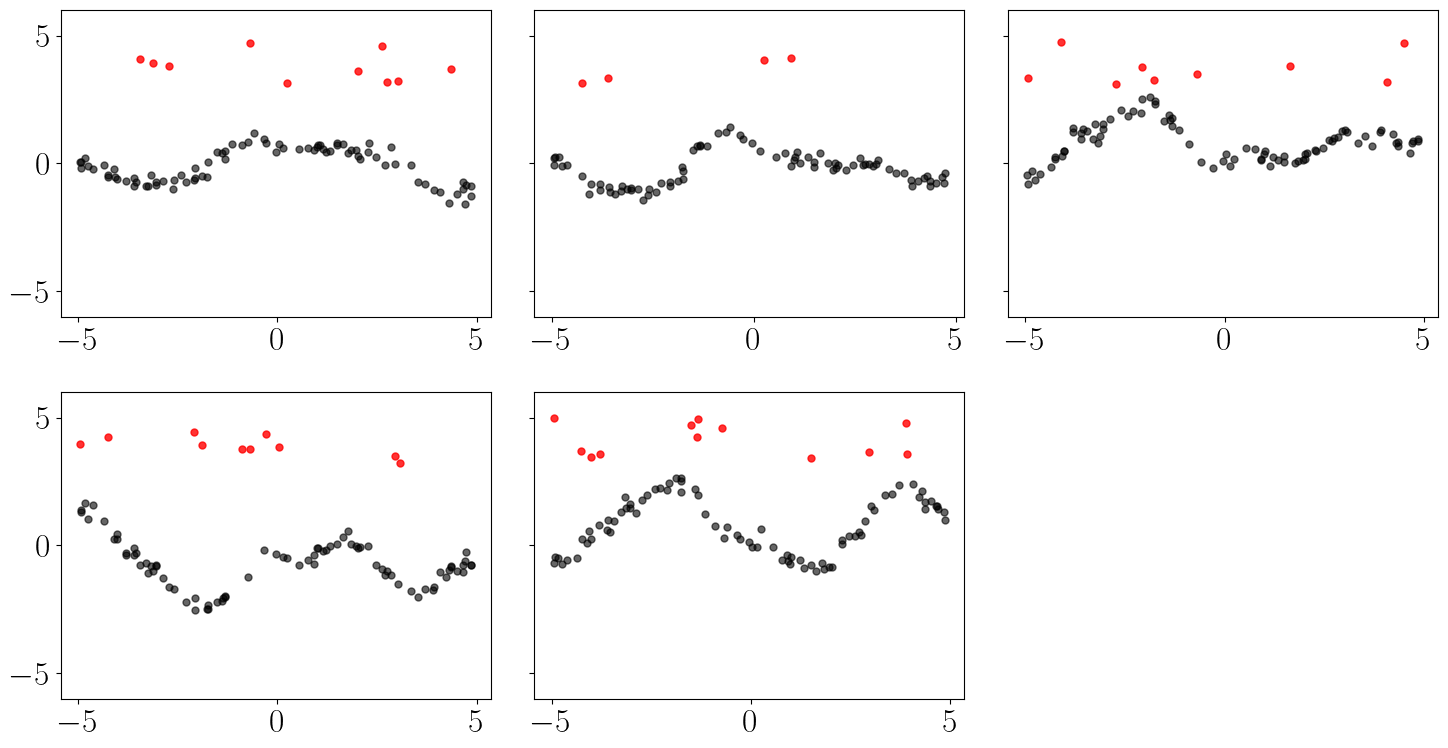

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import cholesky

np.random.seed(42)
train_test_N = 300
N = 100
D = 5  # changed to 5 outputs
noise_var = 0.2
missing_percentage = 0.1 
epsilon = 0.1

lengthscale = 1.0
rbf_variance = 1.0

x = np.sort(np.random.uniform(-5, 5, train_test_N)).reshape(-1, 1)

# Define a 5x5 coregionalization matrix B (symmetric and PSD)
B = np.array([
    [1.0,  0.9,  -0.7,  0.5,  -0.6],
    [0.9,  1.0,  -0.8,  0.6,  -0.7],
    [-0.7, -0.8,  1.0, -0.9,   0.8],
    [0.5,  0.6,  -0.9,  1.0,  -0.85],
    [-0.6, -0.7,  0.8, -0.85,  1.0]
])

A = np.linalg.cholesky(B)

Kx = rbf_kernel(x, x, lengthscale=lengthscale, variance=rbf_variance)
K = np.kron(B, Kx)

# Add a small jitter for numerical stability
L = cholesky(K + 1e-6*np.eye(D*train_test_N), lower=True)

f_samples = L @ np.random.randn(D*train_test_N)
F = f_samples.reshape(D, train_test_N).T
Y = F + np.random.normal(0, noise_var, F.shape)

x_train, Y_train, x_test, Y_test = train_test_split_random(x, Y, N)
Y_train = introduce_missing_values(Y_train, missing_percentage)

# Add 5% outliers uniformly distributed in [-4, -2] ∪ [2, 4]
num_outliers = int(epsilon * N * D * (1 - missing_percentage))
# num_outliers = 0
indices = np.unravel_index(np.random.choice(N * D, num_outliers, replace=False), (N, D))
uniform_outliers = np.random.uniform(0, 1, num_outliers)
outlier_values = np.where(
    uniform_outliers < 0.5,
    np.random.uniform(3, 5, num_outliers),
    np.random.uniform(3, 5, num_outliers)
)
Y_train[indices] = outlier_values

outliers_per_channel = np.bincount(indices[1])
non_nan_counts = np.sum(~np.isnan(Y_train), axis=0)

epsilons = outliers_per_channel / non_nan_counts

# Plotting in 2 rows and 3 columns
fig, axs = plt.subplots(2, 3, figsize=(15, 8))

# Flatten the indices for convenient comparison
outlier_mask = np.zeros((N, D), dtype=bool)
outlier_mask[indices] = True

for i in range(D):
    ax = axs[i // 3, i % 3]
    
    # Separate inliers and outliers
    x_all = x_train.flatten()
    y_all = Y_train[:, i]
    is_outlier = outlier_mask[:, i]

    ax.plot(x_all[~is_outlier], y_all[~is_outlier], 'o', color='black', alpha=0.6, label=f'Output {i+1} - inliers')
    ax.plot(x_all[is_outlier], y_all[is_outlier], 'o', color='red', alpha=0.8, label='Outliers')

    ax.set_ylim([-6, 6])
    if i % 3 != 0:
        ax.set_yticklabels([])

# Hide the unused 6th subplot
axs[1, 2].axis('off')

plt.tight_layout()
plt.show()

## MOGP

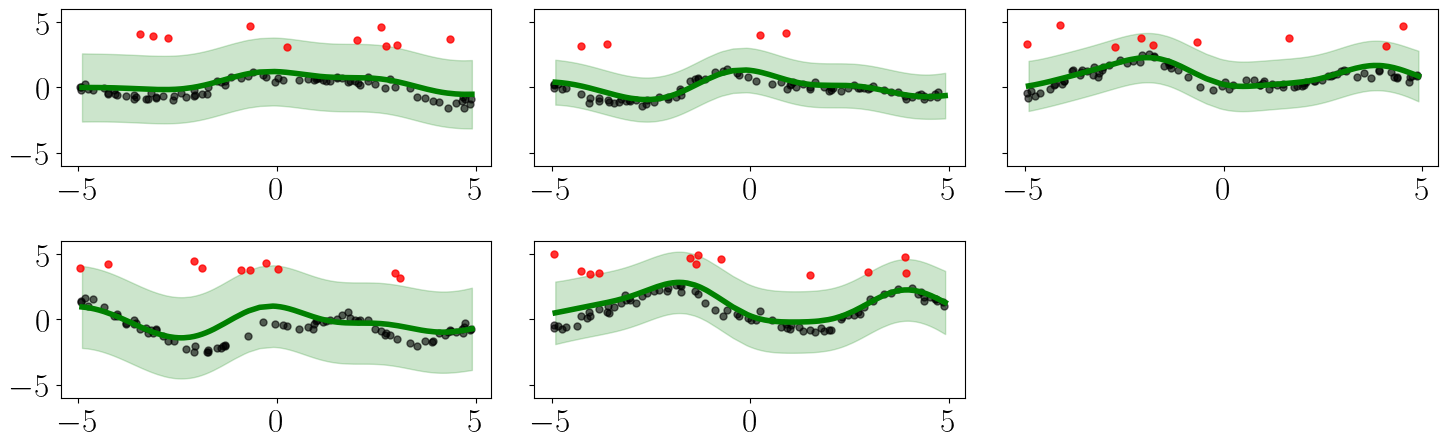

In [13]:
mogp = MOGPRegressor(mean=0, length_scale=1.0, noise = np.array([0.2] * D), A = 2*A)
# mogp = MOGPRegressor_NC(mean=0, length_scale=1.0, noise = 0.2, A = 2*A)
mogp.fit(x_train, Y_train)

mogp.optimize_hyperparameters(
    # print_opt_param=True, print_iter_param=True
    )
# mogp.optimize_loo_cv(print_opt_param=True, print_iter_param=True)

optim_A = mogp.A
optim_noise = mogp.noise
optim_B = optim_A @ optim_A.T
optim_length_scale = mogp.length_scale

# Predict on test points
mu_mogp, var_mogp = mogp.predict(x_test)
std_mogp = np.sqrt(var_mogp + mogp.noise)

# Plotting
fig, axs = plt.subplots(2, 3, figsize=(15, 5))

for i in range(D):
    ax = axs[i // 3, i % 3]
    # Separate inliers and outliers
    x_all = x_train.flatten()
    y_all = Y_train[:, i]
    is_outlier = outlier_mask[:, i]

    ax.plot(x_all[~is_outlier], y_all[~is_outlier], 'o', color='black', alpha=0.6, label=f'Output {i+1} - inliers')
    ax.plot(x_all[is_outlier], y_all[is_outlier], 'o', color='red', alpha=0.8, label='Outliers')
    ax.plot(x_test.flatten(), mu_mogp[:, i], '-', color='Green', label=f'Predicted Mean')
    ax.fill_between(x_test.flatten(), mu_mogp[:, i] - 2*std_mogp[:, i], mu_mogp[:, i] + 2*std_mogp[:, i], color='Green', alpha=0.2, label=f'±2 Std. Dev.')
    ax.set_ylim([-6, 6])
    if i % 3 != 0:
        ax.set_yticklabels([])

# Hide the unused 6th subplot
axs[1, 2].axis('off')

plt.tight_layout()
plt.show()

## MORCGP

-661.5515756917699
-661.5515755871226
-661.5515747126742
-661.5515756055734
-661.5515754011224
-661.5515737568261
-661.5515747936493
-661.551575693834
-661.5515756543278
-661.5515757041069
-661.551575700817
-661.5515757018111
-661.5515756894968
-661.5515757131728
-661.5515756714289
-661.5515756591412
-661.5515756523276
-661.5515756881606
-661.551575661058
-661.5515756733489
-661.5515756746321
-661.5515756315438
-661.5515756877041
-661.5515756693161
-661.5515756439586
-661.5515756708985
-661.5515756593
-661.5515756989574
-661.551575684623
-661.5515756576116
-661.5515756677348
-661.5515756871903
-506.5836643277484
-506.58366438503475
-506.5836638356817
-506.5836642586907
-506.5836641159849
-506.5836637309205
-506.5836638476899
-506.5836643255713
-506.58366429757336
-506.58366432121363
-506.5836643402995
-506.58366431811214
-506.58366432158937
-506.58366435626243
-506.5836643191328
-506.58366428736986
-506.58366429014336
-506.58366431666406
-506.58366431051155
-506.5836642954407
-506.5836

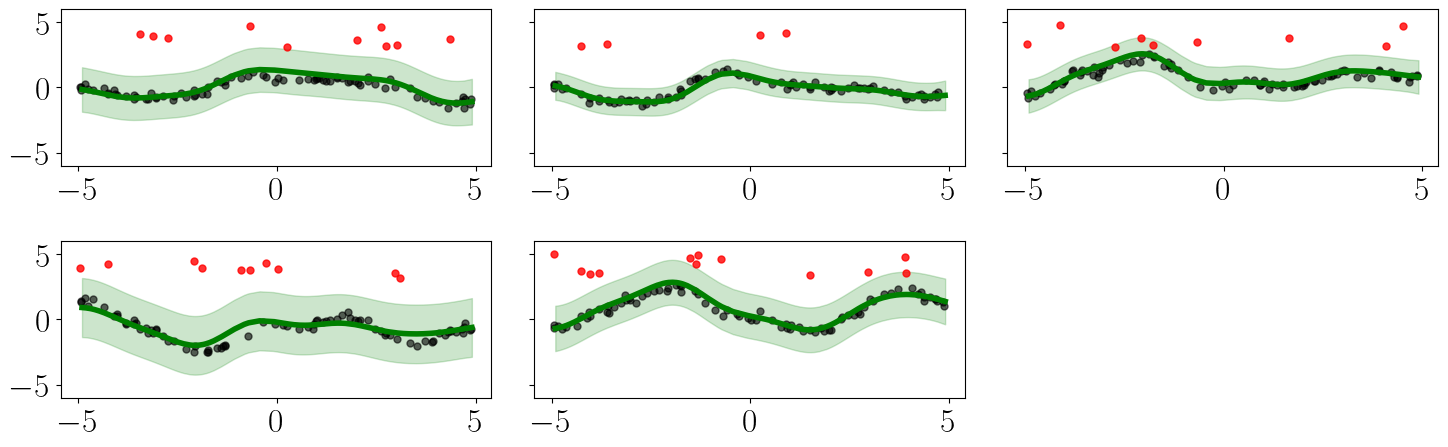

In [14]:
# morcgp = MORCGPRegressor_NC_fixed_weights(mean = 0, length_scale=optim_length_scale, noise = optim_noise, A=A)
morcgp = MORCGPRegressor_fixed_weights(mean = 0, length_scale=lengthscale, noise = np.array([0.2]*D), A=A)
# morcgp = MORCGPRegressor(mean=0, length_scale=lengthscale, noise=np.array([0.2]*D), A=A)
initial_predictive_mean, initial_predictive_variances = morcgp.fit(x_train, Y_train, 
                                                                   B_weighted=optim_B, noise_weighted=optim_noise
                                                                   )

# print(morcgp.loo_cv(length_scale=optim_length_scale, noise=optim_noise, A=A, weighted=False))

# Optimize hyperparameters
predictive_mean, predictive_variances = morcgp.optimize_loo_cv(weighted=True, print_opt_param = True, print_iter_param=True,
                                                            #    B_weighted=A@A.T, noise_weighted=np.array([0.2]*D)
                                                               )

mu_morcgp, var_morcgp = morcgp.predict(x_test)
std_morcgp = np.sqrt(var_morcgp + morcgp.noise)

# Plotting
fig, axs = plt.subplots(2, 3, figsize=(15, 5))

for i in range(D):
    ax = axs[i // 3, i % 3]
    # Separate inliers and outliers
    x_all = x_train.flatten()
    y_all = Y_train[:, i]
    is_outlier = outlier_mask[:, i]

    ax.plot(x_all[~is_outlier], y_all[~is_outlier], 'o', color='black', alpha=0.6, label=f'Output {i+1} - inliers')
    ax.plot(x_all[is_outlier], y_all[is_outlier], 'o', color='red', alpha=0.8, label='Outliers')
    ax.plot(x_test.flatten(), mu_morcgp[:, i], '-', color='Green', label=f'Predicted Mean')
    ax.fill_between(x_test.flatten(), mu_morcgp[:, i] - 2*std_morcgp[:, i], mu_morcgp[:, i] + 2*std_morcgp[:, i], color='Green', alpha=0.2, label=f'±2 Std. Dev.')
    ax.set_ylim([-6, 6])
    if i % 3 != 0:
        ax.set_yticklabels([])

# Hide the unused 6th subplot
axs[1, 2].axis('off')

plt.tight_layout()
plt.show()

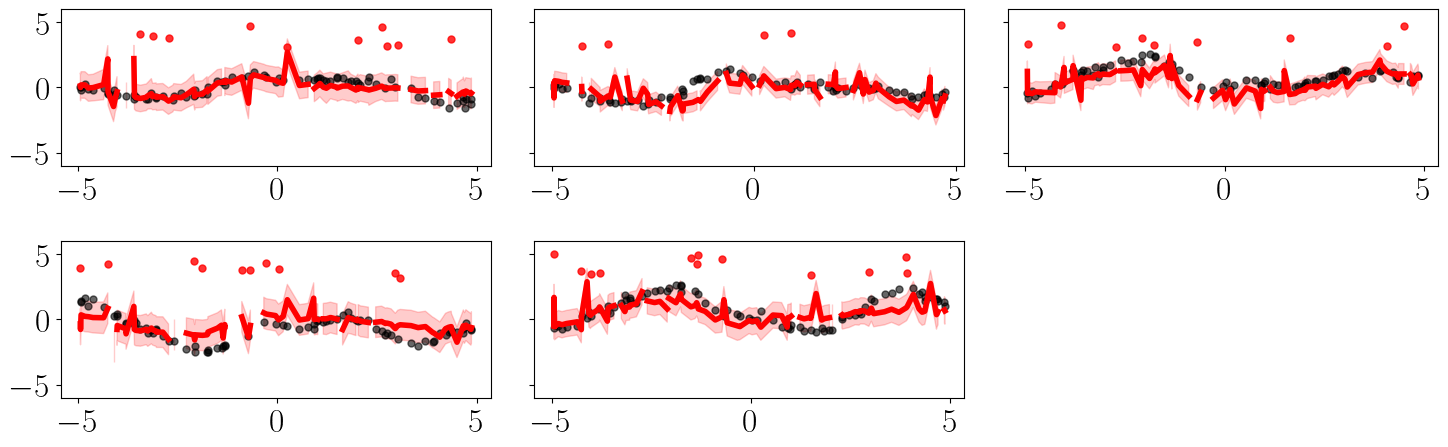

In [15]:
# Plotting
fig, axs = plt.subplots(2, 3, figsize=(15, 5))

for i in range(D):
    ax = axs[i // 3, i % 3]
    # Separate inliers and outliers
    x_all = x_train.flatten()
    y_all = Y_train[:, i]
    is_outlier = outlier_mask[:, i]

    ax.plot(x_all[~is_outlier], y_all[~is_outlier], 'o', color='black', alpha=0.6, label=f'Output {i+1} - inliers')
    ax.plot(x_all[is_outlier], y_all[is_outlier], 'o', color='red', alpha=0.8, label='Outliers')

    ax.plot(x_train.flatten(), predictive_mean[:, i], '-', color='red', label=f'Predictive Mean')
    ax.fill_between(x_train.flatten(), predictive_mean[:, i] - np.sqrt(predictive_variances)[:, i], predictive_mean[:, i] + np.sqrt(predictive_variances)[:, i], color='red', alpha=0.2, label=f'±2 Std. Dev.')

    # ax.plot(x_train.flatten(), initial_predictive_mean[:, i], '-', color='green', label=f'Predictive Mean')
    # ax.fill_between(x_train.flatten(), initial_predictive_mean[:, i] - np.sqrt(initial_predictive_variances)[:, i], initial_predictive_mean[:, i] + np.sqrt(initial_predictive_variances)[:, i], color='green', alpha=0.2, label=f'±2 Std. Dev.')

    ax.set_ylim([-6, 6])
    if i % 3 != 0:
        ax.set_yticklabels([])

# Hide the unused 6th subplot
axs[1, 2].axis('off')

plt.tight_layout()
plt.show()

## MORCGP (RCGP weights)

-467.9335604834235
-467.9335610411044
-467.9335600613373
-467.9335604237893
-467.9335604812685
-467.9335587057021
-467.93356030994863
-467.93356047568915
-467.93356051479077
-467.9335605374544
-467.93356056084724
-467.9335604938717
-467.93356050322325
-467.93356039464686
-467.9335605234729
-467.93356056478825
-467.9335602975723
-467.93356052861435
-467.9335603499932
-467.93356076941143
-467.9335607674276
-467.9335603032767
-467.9335604699988
-467.9335603567307
-467.93356073163096
-467.9335605697447
-467.9335601784118
-467.93356045583823
-467.93356045844024
-467.93356046433496
-467.93356046601167
-467.93356019861466
-350.6746015536436
-350.6746017030957
-350.6746013013432
-350.67460152058294
-350.67460155328
-350.6746010607757
-350.6746014677267
-350.67460154268935
-350.67460158524796
-350.67460156555916
-350.67460153460667
-350.6746015079709
-350.6746015590654
-350.6746015357525
-350.6746015706736
-350.6746015394619
-350.67460153982324
-350.6746015093631
-350.67460155434924
-350.674601

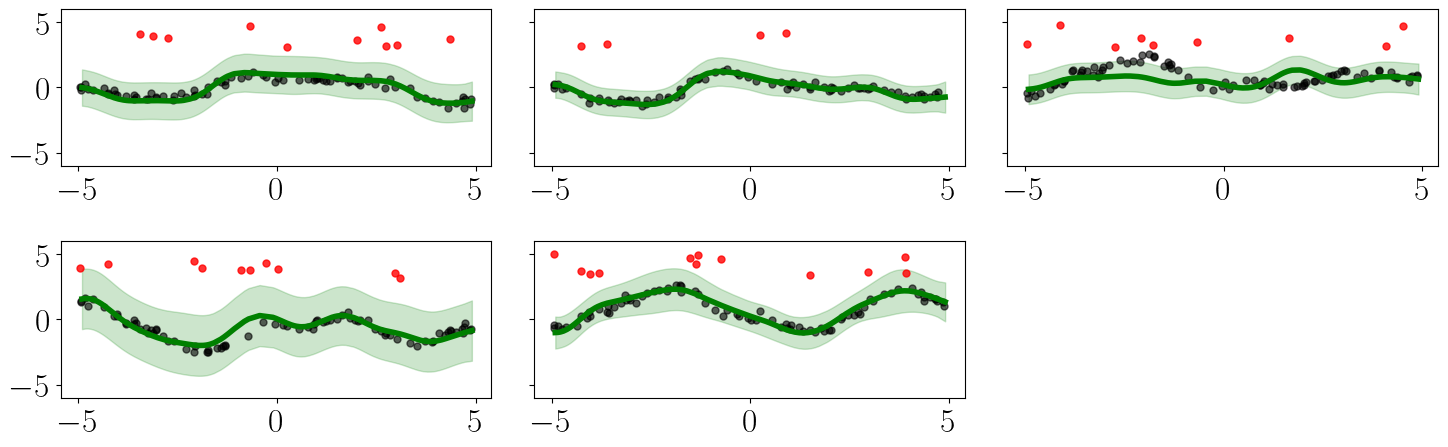

In [12]:
morcgp = MORCGPRegressor_PM(mean=0, length_scale=lengthscale, noise=np.array([0.2]*D), A=A, epsilons=epsilons)
morcgp.fit(x_train, Y_train)

# print(morcgp.loo_cv(length_scale=optim_length_scale, noise=optim_noise, A=A, weighted=False))

morcgp.optimize_loo_cv(weighted=True, print_opt_param = True, print_iter_param=True,
                                                            #    B_weighted=A@A.T, noise_weighted=np.array([0.2]*D)
                                                               )

mu_pm, var_pm = morcgp.predict(x_test)
std_pm = np.sqrt(var_pm + morcgp.noise)

# Plotting
fig, axs = plt.subplots(2, 3, figsize=(15, 5))

for i in range(D):
    ax = axs[i // 3, i % 3]
    # Separate inliers and outliers
    x_all = x_train.flatten()
    y_all = Y_train[:, i]
    is_outlier = outlier_mask[:, i]

    ax.plot(x_all[~is_outlier], y_all[~is_outlier], 'o', color='black', alpha=0.6, label=f'Output {i+1} - inliers')
    ax.plot(x_all[is_outlier], y_all[is_outlier], 'o', color='red', alpha=0.8, label='Outliers')
    ax.plot(x_test.flatten(), mu_pm[:, i], '-', color='Green', label=f'Predicted Mean')
    ax.fill_between(x_test.flatten(), mu_pm[:, i] - 2*std_pm[:, i], mu_pm[:, i] + 2*std_pm[:, i], color='Green', alpha=0.2, label=f'±2 Std. Dev.')
    ax.set_ylim([-6, 6])
    if i % 3 != 0:
        ax.set_yticklabels([])

# Hide the unused 6th subplot
axs[1, 2].axis('off')

plt.tight_layout()
plt.show()

## RCGP

-357.60773788325406
-357.60773818272173
-357.6077349733567
-357.60773784442324
-188.60789603890956
-188.60789611040988
-188.6078952400882
-188.60789602857386
-166.12152392861393
-166.12152396383777
-166.1215235173452
-166.12152392508327
-155.5667036292569
-155.56670364135266
-155.56670349704626
-155.56670363176116
-154.00394253943588
-154.003942544432
-154.00394250522322
-154.0039425445259
-153.86592567768238
-153.8659256805056
-153.86592567385009
-153.86592568366743
-153.85252484000225
-153.85252484227865
-153.85252484141915
-153.85252484615967
-153.8203903476756
-153.8203903487442
-153.82039035689516
-153.8203903540921
-153.74820077721762
-153.74820077584667
-153.74820079654933
-153.74820078369524
-153.646812140777
-153.64681213553627
-153.6468121671882
-153.6468121450308
-153.56717269801186
-153.56717269343537
-153.56717271707888
-153.5671727000045
-153.50208008529916
-153.50208008582837
-153.5020800818917
-153.50208008563746
-153.50018352064797
-153.5001835202189
-153.5001835201381

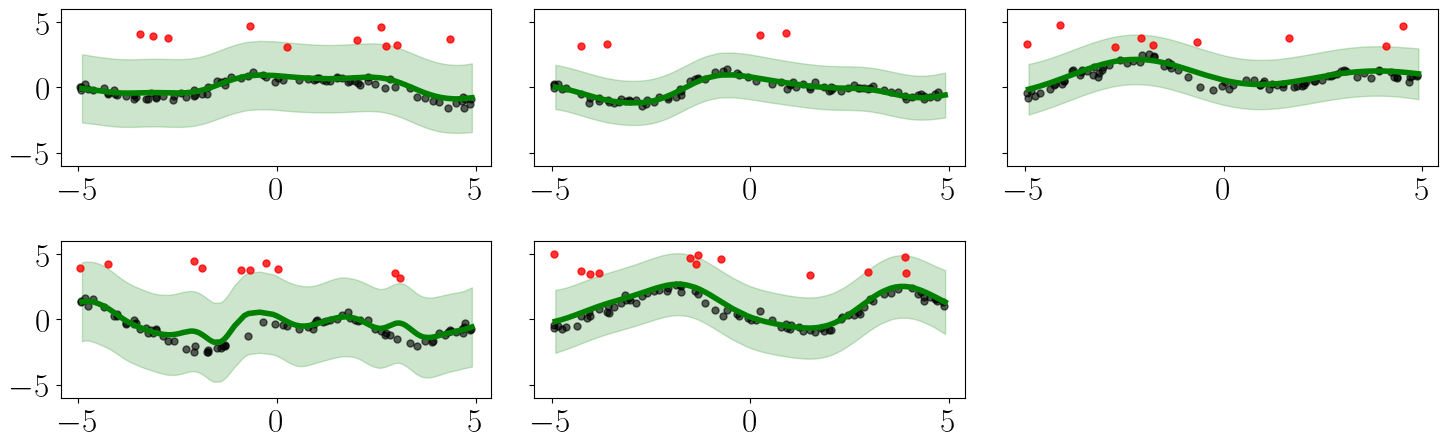

In [16]:
prior_mean = ConstantMean(constant=0.0)

mu_rcgp, std_rcgp = np.full_like(Y_test, np.nan), np.full_like(Y_test, np.nan)

for d in range(D):
    rcgp = RCGPRegressor(mean=prior_mean, length_scale=lengthscale, rbf_variance=rbf_variance, noise=noise_var, epsilon=epsilon)
    rcgp.fit(x_train[~np.isnan(Y_train[:, d])], Y_train[:, d][~np.isnan(Y_train[:, d])].reshape(-1, 1))

    rcgp.optimize_loo_cv(print_opt_param=True, print_iter_param=True, weighted=False)

    mu_rcgp[:, d], var_rcgp = rcgp.predict(x_test)
    std_rcgp[:, d] = np.sqrt(var_rcgp + rcgp.noise)

# Plotting
fig, axs = plt.subplots(2, 3, figsize=(15, 5))

for i in range(D):
    ax = axs[i // 3, i % 3]
    # Separate inliers and outliers
    x_all = x_train.flatten()
    y_all = Y_train[:, i]
    is_outlier = outlier_mask[:, i]

    ax.plot(x_all[~is_outlier], y_all[~is_outlier], 'o', color='black', alpha=0.6, label=f'Output {i+1} - inliers')
    ax.plot(x_all[is_outlier], y_all[is_outlier], 'o', color='red', alpha=0.8, label='Outliers')
    ax.plot(x_test.flatten(), mu_rcgp[:, i], '-', color='Green', label=f'Predicted Mean')
    ax.fill_between(x_test.flatten(), mu_rcgp[:, i] - 2*std_rcgp[:, i], mu_rcgp[:, i] + 2*std_rcgp[:, i], color='Green', alpha=0.2, label=f'±2 Std. Dev.')
    ax.set_ylim([-6, 6])
    if i % 3 != 0:
        ax.set_yticklabels([])

# Hide the unused 6th subplot
axs[1, 2].axis('off')

plt.tight_layout()
plt.show()

## Combined

In [17]:
def calculate_rmse(y_true, y_pred):
    errors = y_true - y_pred
    squared_errors = errors ** 2
    mse = np.mean(squared_errors)
    rmse = np.sqrt(mse)
    return rmse

def nlpd(Y_true, mu_pred, var_pred):
    # Avoid zero or negative variances by adding a small number epsilon if needed
    epsilon = 1e-10
    var_pred = np.maximum(var_pred, epsilon)
    
    # Compute NLPD per test point
    nlpd_values = 0.5 * np.log(2 * np.pi * var_pred) + ((Y_true - mu_pred) ** 2) / (2 * var_pred)
    
    # Average NLPD over all test points
    return np.mean(nlpd_values)

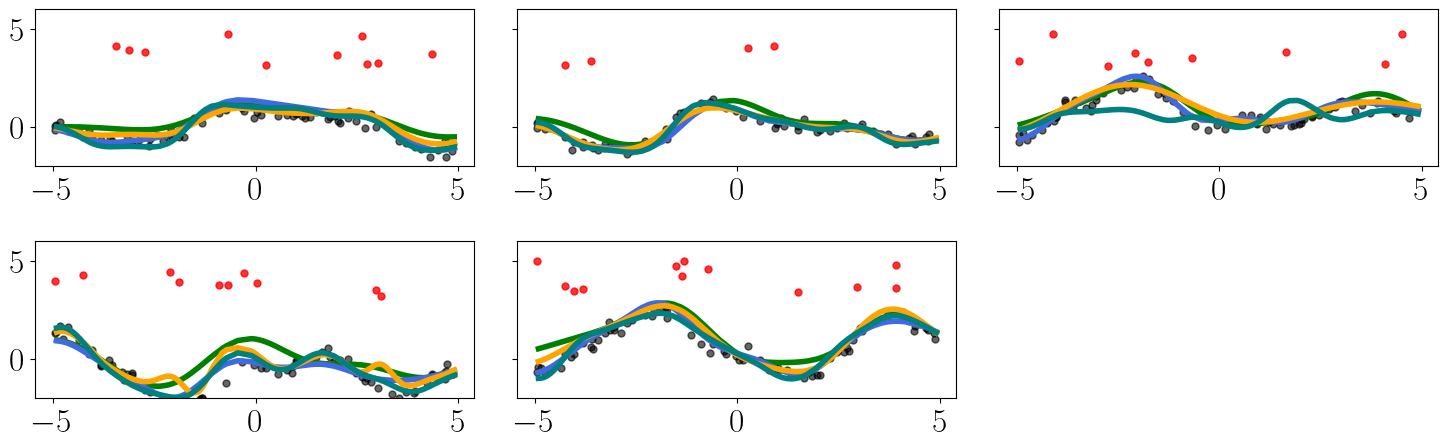

In [18]:
# Plotting
fig, axs = plt.subplots(2, 3, figsize=(15, 5))

for i in range(D):
    ax = axs[i // 3, i % 3]
    # Separate inliers and outliers
    x_all = x_train.flatten()
    y_all = Y_train[:, i]
    is_outlier = outlier_mask[:, i]

    ax.plot(x_all[~is_outlier], y_all[~is_outlier], 'o', color='black', alpha=0.6, label=f'Output {i+1} - inliers')
    ax.plot(x_all[is_outlier], y_all[is_outlier], 'o', color='red', alpha=0.8, label='Outliers')

    # MOGP
    ax.plot(x_test.flatten(), mu_mogp[:, i], '-', color='Green', label=f'Predicted Mean')
    # ax.fill_between(x_test.flatten(), mu_mogp[:, i] - 2*std_mogp[:, i], mu_mogp[:, i] + 2*std_mogp[:, i], color='Blue', alpha=0.2, label=f'±2 Std. Dev.')

    # MORCGP
    ax.plot(x_test.flatten(), mu_morcgp[:, i], '-', color='RoyalBlue', label=f'Predicted Mean')
    # ax.fill_between(x_test.flatten(), mu_morcgp[:, i] - 2*std_morcgp[:, i], mu_morcgp[:, i] + 2*std_morcgp[:, i], color='Green', alpha=0.2, label=f'±2 Std. Dev.')

    # RCGP
    ax.plot(x_test.flatten(), mu_rcgp[:, i], '-', color='Orange', label=f'Predicted Mean')
    # ax.fill_between(x_test.flatten(), mu_rcgp[:, i] - 2*std_rcgp[:, i], mu_rcgp[:, i] + 2*std_rcgp[:, i], color='Red', alpha=0.2, label=f'±2 Std. Dev.')

    # MORCGP (RCGP weights)
    ax.plot(x_test.flatten(), mu_pm[:, i], '-', color='Teal', label=f'Predicted Mean')
    # ax.fill_between(x_test.flatten(), mu_pm[:, i] - 2*std_pm[:, i], mu_pm[:, i] + 2*std_pm[:, i], color='Teal', alpha=0.2, label=f'±2 Std. Dev.')

    ax.set_ylim([-2, 6])
    if i % 3 != 0:
        ax.set_yticklabels([])

# Hide the unused 6th subplot
axs[1, 2].axis('off')

plt.tight_layout()
plt.show()

In [20]:
rmse_mogp = calculate_rmse(Y_test, mu_mogp)
rmse_morcgp = calculate_rmse(Y_test, mu_morcgp)
rmse_rcgp = calculate_rmse(Y_test, mu_rcgp)
rmse_pm = calculate_rmse(Y_test, mu_pm)

print("RMSE MOGP:", rmse_mogp)
print("RMSE MORCGP:", rmse_morcgp)
print("RMSE RCGP:", rmse_rcgp)
print("RMSE MORCGP (PM):", rmse_pm)

nlpd_mogp = nlpd(Y_test, mu_mogp, std_mogp**2)
nlpd_morcgp = nlpd(Y_test, mu_morcgp, std_morcgp**2)
nlpd_rcgp = nlpd(Y_test, mu_rcgp, std_rcgp**2)
nlpd_pm = nlpd(Y_test, mu_pm, std_pm**2)

print("NLPD MOGP:", nlpd_mogp)
print("NLPD MORCGP:", nlpd_morcgp)
print("NLPD RCGP:", nlpd_rcgp)
print("NLPD MORCGP (PM):", nlpd_pm)

RMSE MOGP: 0.5899045164368237
RMSE MORCGP: 0.3325691566591157
RMSE RCGP: 0.4009187751364645
RMSE MORCGP (PM): 0.46770334030327887
NLPD MOGP: 1.1674799930758195
NLPD MORCGP: 0.7482022766369963
NLPD RCGP: 1.0978705228431753
NLPD MORCGP (PM): 0.8364218040198289
